In [29]:
import pandas as pd

# Load the CSV file
df = pd.read_csv("../data/prompt_engineering/gpt_files/GPT_subset_triples_prompt2_param1.csv")

# Count unique URLs
unique_url_count = df['URL'].nunique()

print(f"Number of unique URLs: {unique_url_count}")

Number of unique URLs: 44


In [9]:
import pandas as pd
import requests
from urllib.parse import urlparse
from tqdm import tqdm

# Load the Excel file
#df = pd.read_excel("../data/CBM_data/Data_CBM.xlsx")
df = pd.read_excel("../data/CBM_data/Data_CBM_with_GitHub_URLs.xlsx")

# Get unique URLs
urls = df['GitHub_Image_URL'].dropna().unique().tolist()

# Diagnostic function
def diagnose_url(url):
    headers = {"User-Agent": "Mozilla/5.0"}
    result = {
        'URL': url,
        'Status': None,
        'Content-Type': None,
        'Redirect': None,
        'Is HTTPS': url.startswith("https://"),
        'Likely GPT-Compatible': False,
        'Error': None
    }
    
    try:
        # HEAD first (faster), fallback to GET
        r = requests.head(url, headers=headers, timeout=10, allow_redirects=True)
        if r.status_code in [405, 403, 400]:  # Some sites block HEAD
            r = requests.get(url, headers=headers, timeout=10, stream=True, allow_redirects=True)
        
        result['Status'] = r.status_code
        result['Content-Type'] = r.headers.get('Content-Type', None)
        result['Redirect'] = r.url if r.url != url else None
        
        # Basic heuristics for GPT compatibility
        if (
            r.status_code == 200 and
            result['Content-Type'] is not None and
            result['Content-Type'].startswith("image") and
            result['Is HTTPS']
        ):
            result['Likely GPT-Compatible'] = True

    except Exception as e:
        result['Error'] = str(e)

    return result

# Run diagnostics
diagnostics = [diagnose_url(url) for url in tqdm(urls)]

# Convert to DataFrame
df_diag = pd.DataFrame(diagnostics)

# Show problematic URLs
bad_urls = df_diag[~df_diag['Likely GPT-Compatible']]
print(f"\n⚠️ Found {len(bad_urls)} potentially problematic URLs out of {len(urls)}.")
bad_urls[['URL', 'Status', 'Content-Type', 'Redirect', 'Error']]

# Optionally: save to Excel
df_diag.to_excel("../data/CBM_data/CBM_URL_Diagnostics.xlsx", index=False)


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:20<00:00,  4.90it/s]


⚠️ Found 0 potentially problematic URLs out of 100.


In [3]:
import pandas as pd

# Load the diagnostics file
df_diag = pd.read_excel("../data/CBM_data/CBM_URL_Diagnostics.xlsx")

# Filter only failed cases
bad_urls = df_diag[df_diag['Likely GPT-Compatible'] == False]

# Check Content-Type and extension
def is_likely_html(row):
    content_type = str(row['Content-Type']).lower()
    url = str(row['URL']).lower()
    return (
        'html' in content_type or
        'text' in content_type or
        '?' in url or
        not url.endswith(('.jpg', '.jpeg', '.png', '.gif', '.svg'))
    )

# Flag suspicious MIME type or URL pattern
bad_urls['Looks like HTML or wrapper'] = bad_urls.apply(is_likely_html, axis=1)

# Show results
print(f"⚠️ Suspicious URLs (non-image content or dynamic endpoints):")
bad_urls[bad_urls['Looks like HTML or wrapper']][['URL', 'Content-Type', 'Redirect']]


⚠️ Suspicious URLs (non-image content or dynamic endpoints):


C:\Users\User\AppData\Local\Temp\ipykernel_3476\630145008.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bad_urls['Looks like HTML or wrapper'] = bad_urls.apply(is_likely_html, axis=1)


,URL,Content-Type,Redirect
0,https://www.mdpi.com/cells/cells-12-00816/arti...,text/html,NaN
2,https://www.mdpi.com/cells/cells-12-00684/arti...,text/html,NaN
10,https://www.mdpi.com/ijms/ijms-22-04081/articl...,text/html,NaN
12,https://www.mdpi.com/jcm/jcm-10-01947/article_...,text/html,NaN
19,https://www.mdpi.com/life/life-12-00285/articl...,text/html,NaN
21,https://www.mdpi.com/viruses/viruses-15-01598/...,text/html,NaN
27,https://www.mdpi.com/ijms/ijms-22-04081/articl...,text/html,NaN
31,https://www.mdpi.com/viruses/viruses-15-00400/...,text/html,NaN
39,https://www.mdpi.com/brainsci/brainsci-13-0013...,text/html,NaN
44,https://www.mdpi.com/brainsci/brainsci-10-0085...,text/html,NaN


In [7]:
import pandas as pd

# Load the file
df = pd.read_excel("../data/CBM_data/Data_CBM.xlsx")

# Add GitHub raw URL column based on Image_number
base_url = "https://raw.githubusercontent.com/Elly0w0/image-based-information-extraction-LLM-main/main/data/CBM_data/images_CBM/"

df['GitHub_Image_URL'] = df['Image_number'].apply(lambda x: f"{base_url}{x}.jpg")

# Save updated file (optional)
df.to_excel("../data/CBM_data/Data_CBM_with_GitHub_URLs.xlsx", index=False)

# Preview
df[['Image_number', 'GitHub_Image_URL']].head()

,Image_number,GitHub_Image_URL
0,image_1,https://raw.githubusercontent.com/Elly0w0/imag...
1,image_2,https://raw.githubusercontent.com/Elly0w0/imag...
2,image_3,https://raw.githubusercontent.com/Elly0w0/imag...
3,image_4,https://raw.githubusercontent.com/Elly0w0/imag...
4,image_5,https://raw.githubusercontent.com/Elly0w0/imag...


Adding URLs to full text triples file

In [30]:
import pandas as pd

# Load both files
cbm_df = pd.read_excel("../data/CBM_data/Data_CBM.xlsx")
triples_df = pd.read_excel("../data/triples_output/Triples_From_Full_Text_CBM.xlsx")

# Clean PMIDs: remove commas and convert to string for reliable merge
cbm_df["PMID_clean"] = cbm_df["PMID"].astype(str).str.replace(",", "")
triples_df["PMID_clean"] = triples_df["Article ID"].astype(str)

# Map PMID to Image URL (from 'URL' column)
pmid_to_url = cbm_df.set_index("PMID_clean")["URL"].to_dict()

# Add URL column to triples dataframe
triples_df["Image_URL"] = triples_df["PMID_clean"].map(pmid_to_url)

# Drop helper column if not needed
triples_df.drop(columns=["PMID_clean"], inplace=True)

# Save or display the updated dataframe
triples_df.to_excel("../data/triples_output/Triples_From_Full_Text_CBM_with_URLs.xlsx", index=False)
triples_df.to_csv("../data/triples_output/Triples_From_Full_Text_CBM_with_URLs.csv", index=False)

# Optionally show sample
triples_df.head()


,Article ID,Title,Paragraph,Pathophysiological Process,Subject,Predicate,Object,Image_URL
0,36899952,Pathogenesis Underlying Neurological Manifesta...,Relating specifically to neurological symptoms...,Hematogenous_Spread,SARS-CoV-2,invades,choroid_plexus_cells,https://www.mdpi.com/cells/cells-12-00816/arti...
1,36899952,Pathogenesis Underlying Neurological Manifesta...,Relating specifically to neurological symptoms...,Hematogenous_Spread,ACE2_receptors,are_expressed_on,choroid_epithelium,https://www.mdpi.com/cells/cells-12-00816/arti...
2,36899952,Pathogenesis Underlying Neurological Manifesta...,Relating specifically to neurological symptoms...,Hematogenous_Spread,SARS-CoV-2,causes,ependymal_cell_death,https://www.mdpi.com/cells/cells-12-00816/arti...
3,36899952,Pathogenesis Underlying Neurological Manifesta...,Relating specifically to neurological symptoms...,Hematogenous_Spread,SARS-CoV-2,disrupts,blood–CSF_barrier,https://www.mdpi.com/cells/cells-12-00816/arti...
4,36899952,Pathogenesis Underlying Neurological Manifesta...,"In contrast, persistent anosmia is a symptom o...",Viral_Damage_to_Olfactory_Epithelium,SARS-CoV-2,infects,non-neural_cell_types,https://www.mdpi.com/cells/cells-12-00816/arti...


In [2]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


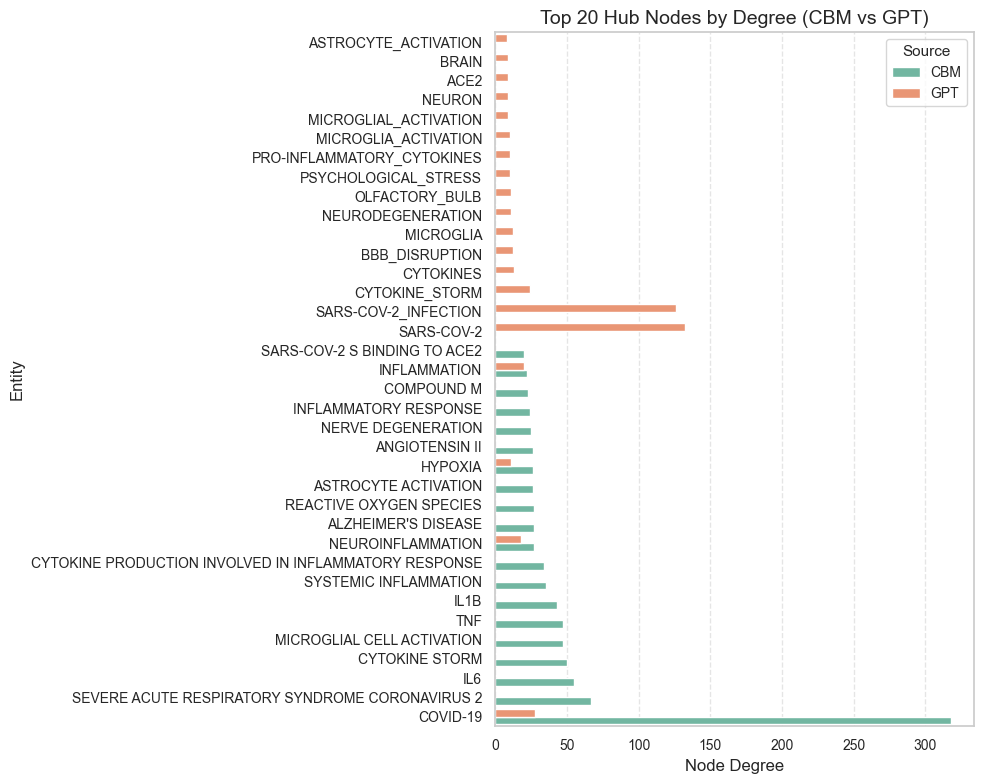

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка CSV-файлов
cbm_df = pd.read_csv("../neo4j_query_table_data_CBM.csv")
gpt_df = pd.read_csv("../neo4j_query_table_data_GPT.csv")

# Добавляем метку источника
cbm_df["source"] = "CBM"
gpt_df["source"] = "GPT"

# Отбираем топ-20 по каждому источнику
top_cbm = cbm_df.sort_values(by="degree", ascending=False).head(20)
top_gpt = gpt_df.sort_values(by="degree", ascending=False).head(20)

# Объединяем
top_combined = pd.concat([top_cbm, top_gpt], ignore_index=True)

# Настройка стиля
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))

# Строим горизонтальный barplot
sns.barplot(
    data=top_combined,
    y="entity",
    x="degree",
    hue="source",
    palette="Set2",
    dodge=True
)

# Подписи и стиль
plt.title("Top 20 Hub Nodes by Degree (CBM vs GPT)", fontsize=14)
plt.xlabel("Node Degree", fontsize=12)
plt.ylabel("Entity", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Source", fontsize=10, title_fontsize=11)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.grid(axis="x", linestyle="--", alpha=0.5)

# Сохраняем в формате PNG и PDF
plt.savefig("../supplementary_hub_nodes.png", dpi=300)
plt.savefig("../supplementary_hub_nodes.tiff", dpi=300)

plt.show()


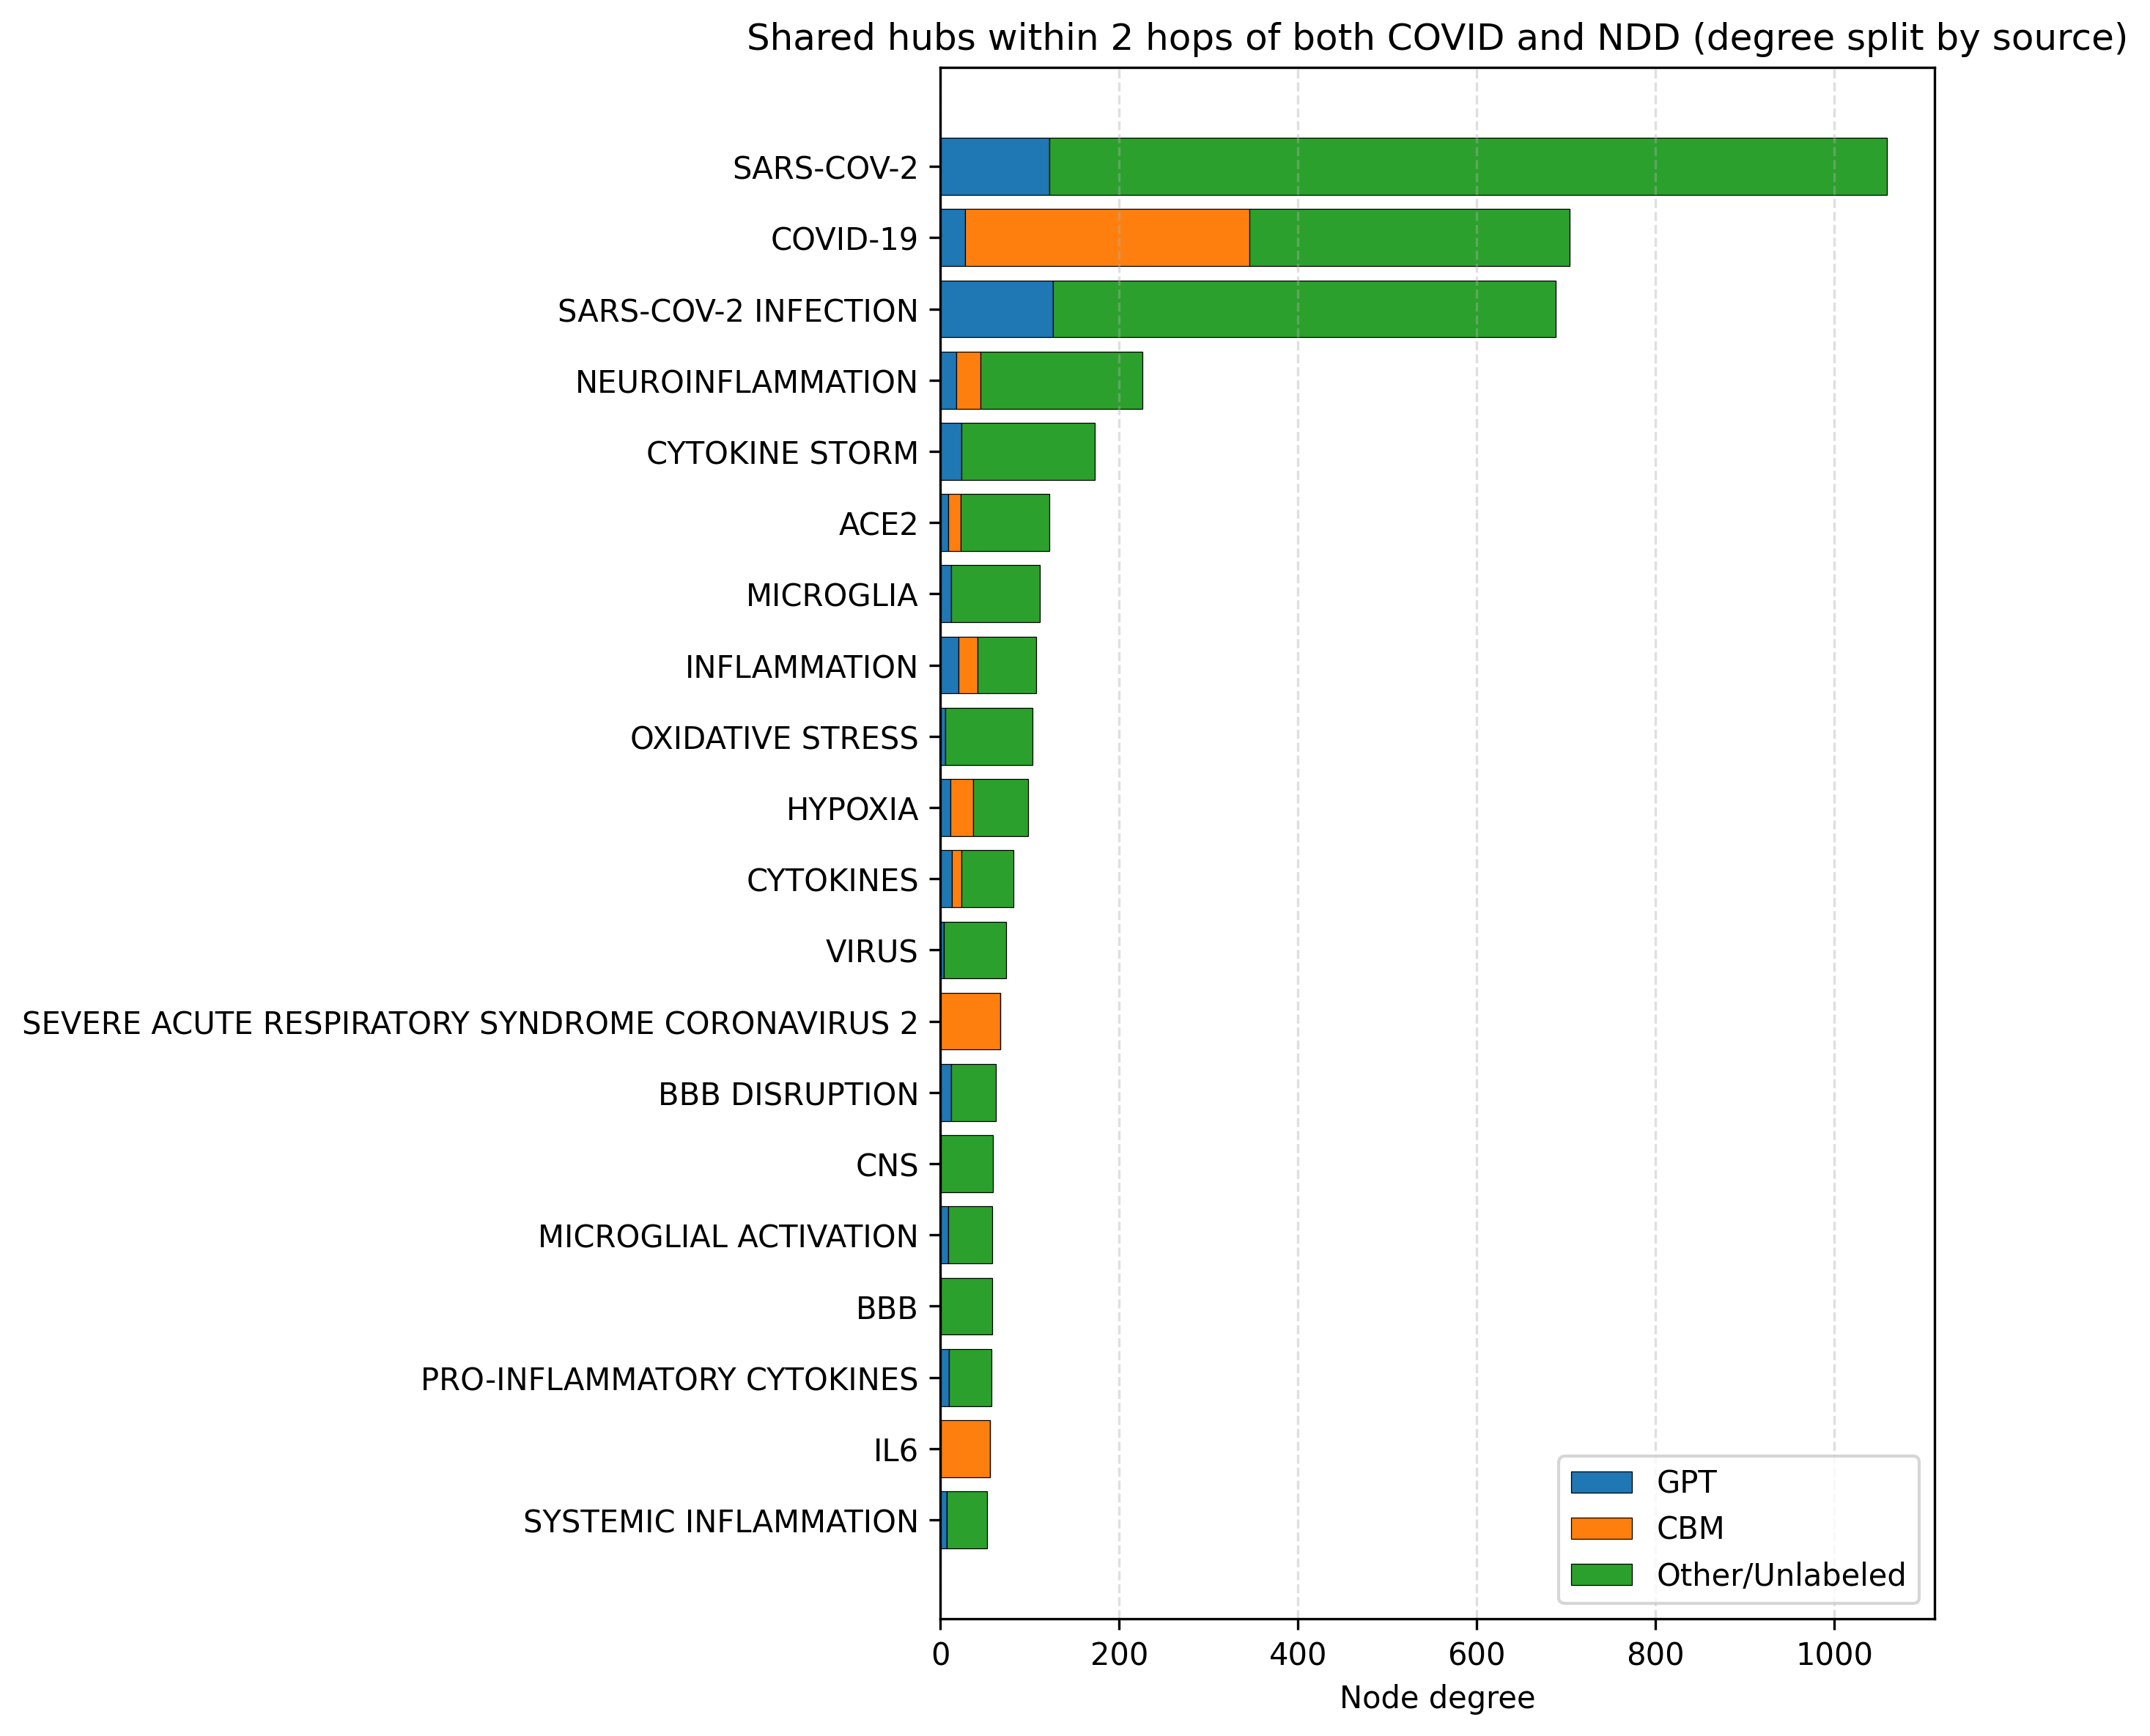

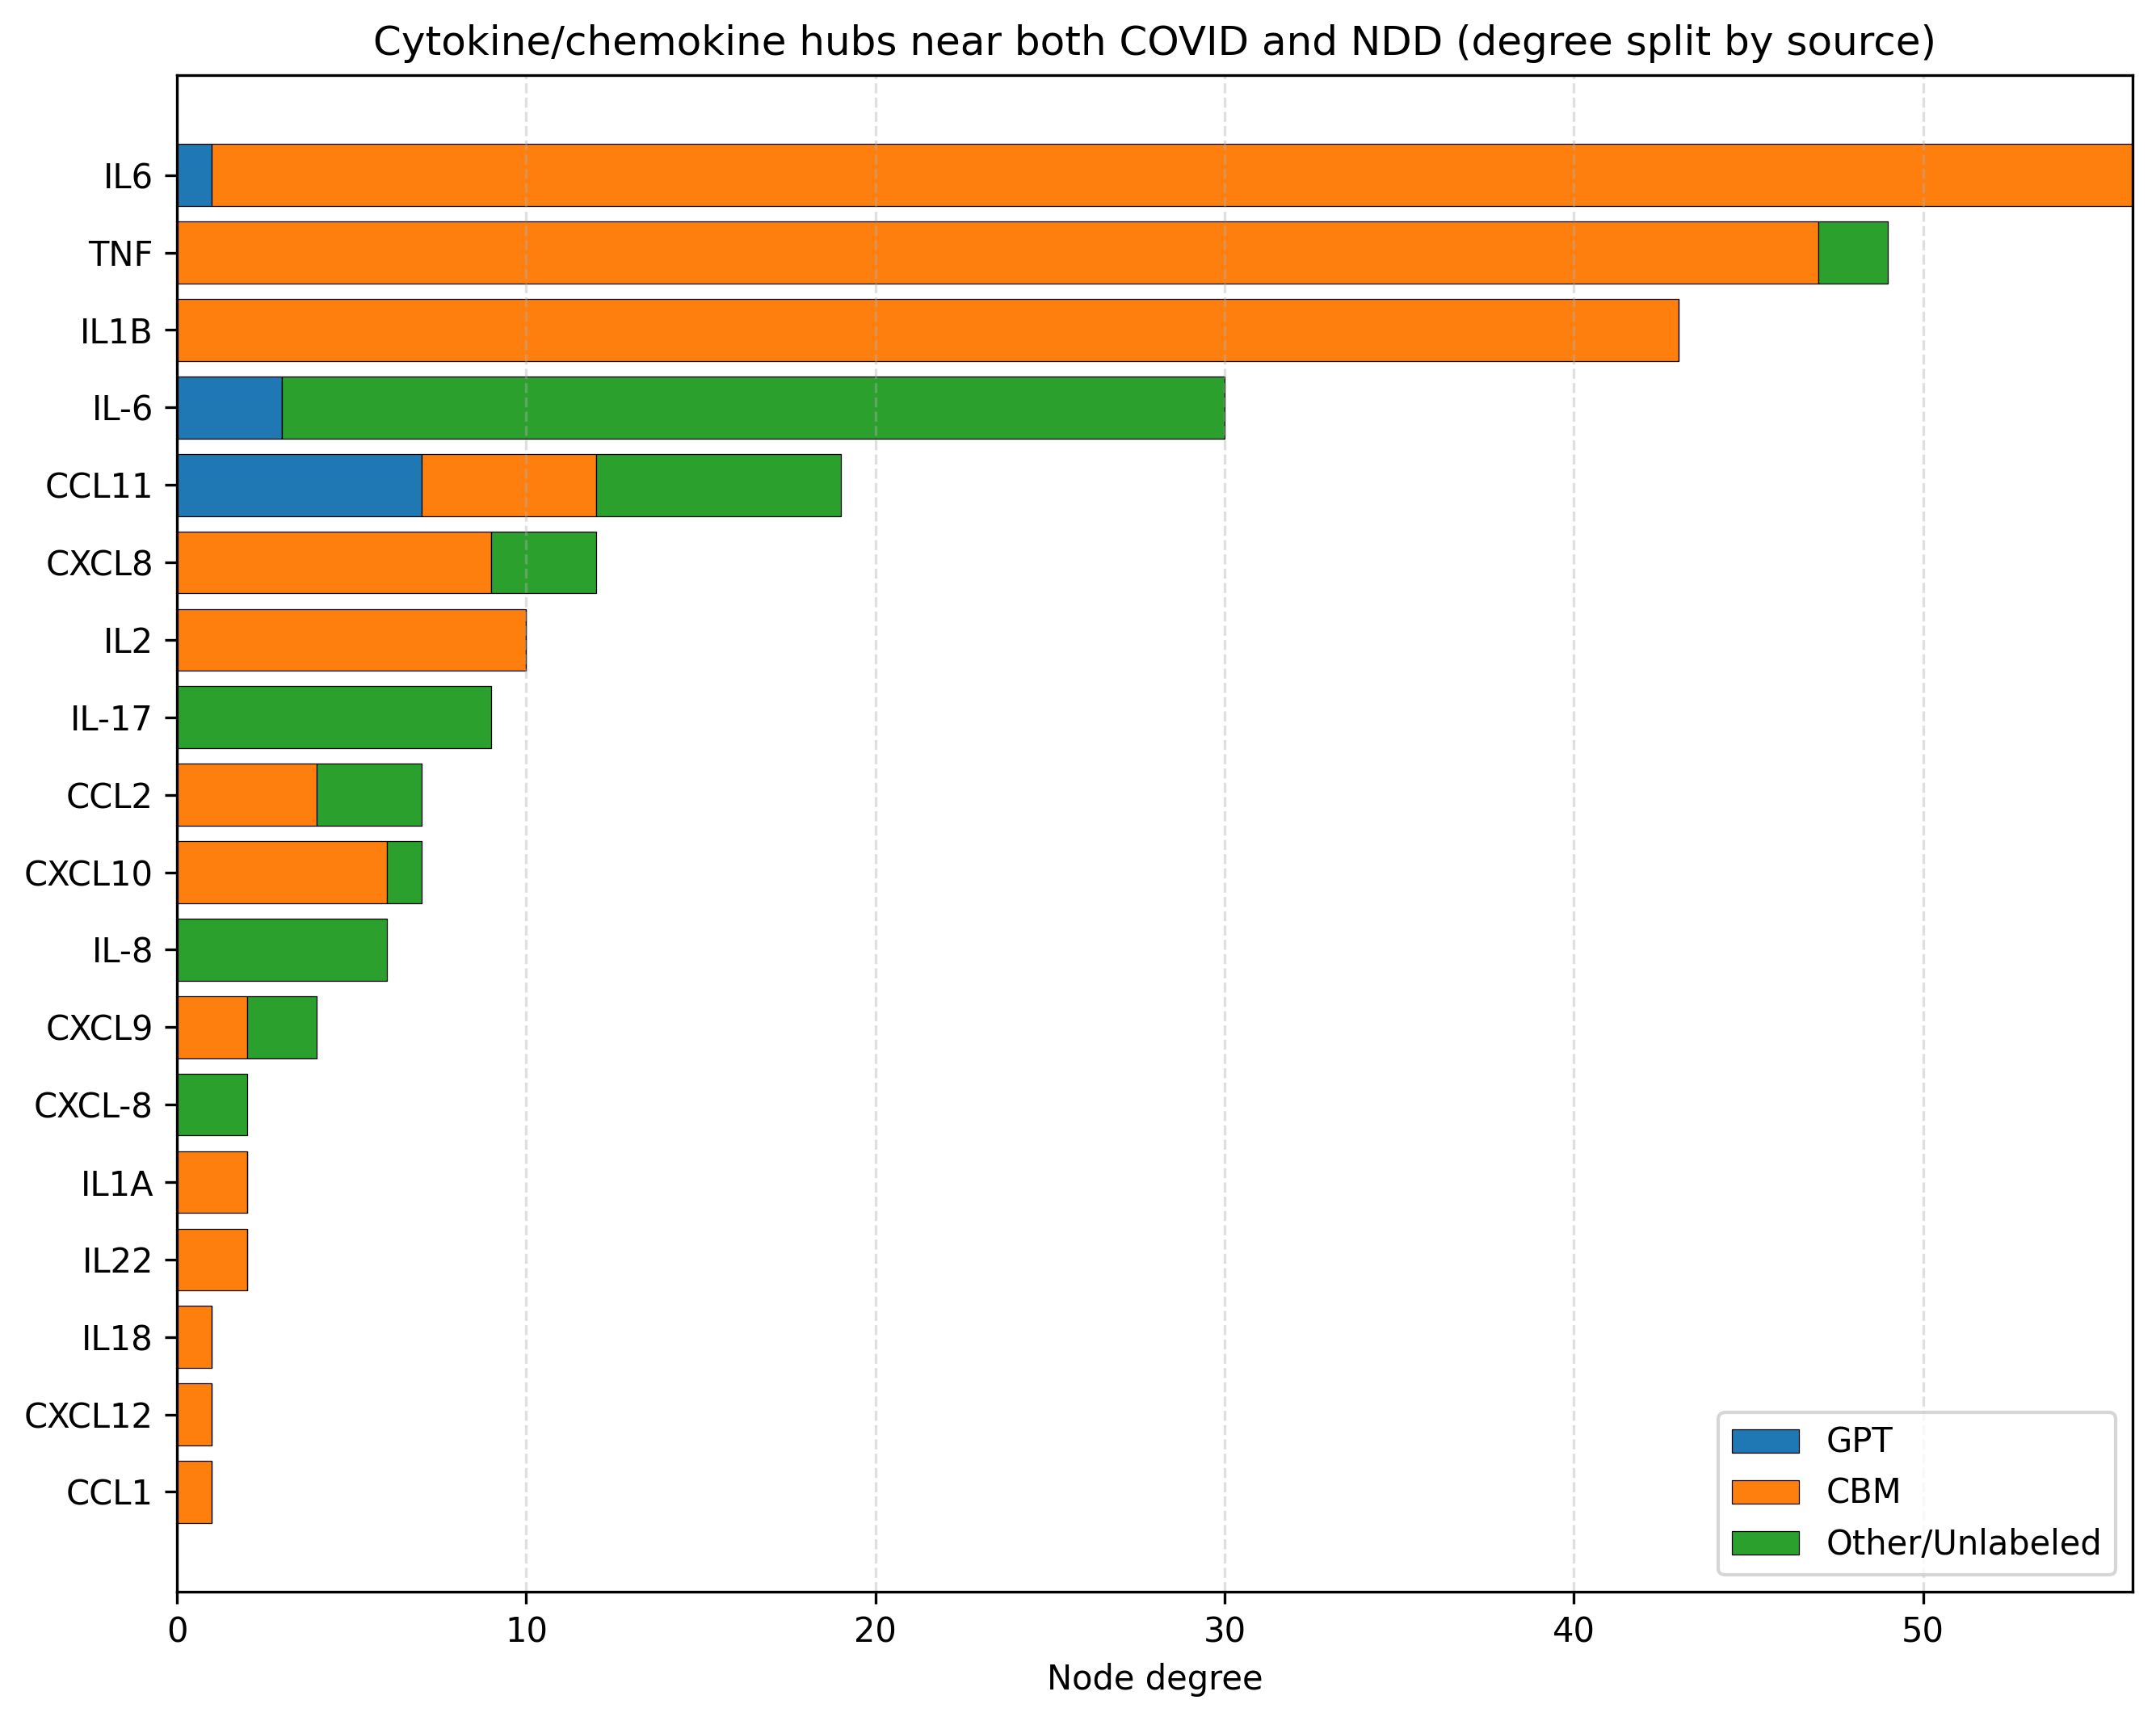

Saved:
 - ../data/bio_insides/outputs\Fig_Q1A_shared_hubs.png
 - ../data/bio_insides/outputs\Fig_Q1B_cytokine_hubs.png
 - ../data/bio_insides/outputs\Q1A_shared_hubs_topN.csv
 - ../data/bio_insides/outputs\Q1B_cytokine_hubs_topN.csv


In [ ]:
# --- Q1A/Q1B visualization: shared hubs & cytokine-focused hubs ---
# Requirements: pandas, matplotlib
# Inputs: CSVs exported from Neo4j Browser:
#   Q1A.csv with columns:  entity, labels, deg_total, deg_cbm, deg_gpt
#   Q1B.csv with columns:  cytokine (or entity), labels, deg_total, deg_cbm, deg_gpt
# Outputs:
#   /mnt/data/Fig_Q1A_shared_hubs.png
#   /mnt/data/Fig_Q1B_cytokine_hubs.png
#   /mnt/data/Q1A_shared_hubs_topN.csv
#   /mnt/data/Q1B_cytokine_hubs_topN.csv

import os
import math
import pandas as pd
import matplotlib.pyplot as plt

# ---------- CONFIG ----------
q1a_path = "../data/bio_insides/Q1A.csv"   # change if needed
q1b_path = "../data/bio_insides/Q1B.csv"   # change if needed
out_dir  = "../data/bio_insides/outputs"
top_n    = 20          # how many entities to show per plot
dpi      = 300

os.makedirs(out_dir, exist_ok=True)

def _standardize_columns(df: pd.DataFrame, kind: str) -> pd.DataFrame:
    """
    Bring Q1A/Q1B result frames to a common schema:
      - name:       entity/cytokine string
      - deg_total:  total degree
      - deg_cbm:    degree from CBM edges
      - deg_gpt:    degree from GPT edges
      - deg_other:  residual degree (if any properties lacked provenance)
    """
    df = df.copy()
    # Detect the name column
    name_col = None
    for cand in ["entity", "cytokine", "name", "x.name", "x"]:
        if cand in df.columns:
            name_col = cand
            break
    if name_col is None:
        raise ValueError(f"Cannot find name/identifier column in {kind} dataframe: {df.columns.tolist()}")
    df.rename(columns={name_col: "name"}, inplace=True)

    # Required numeric columns
    for col in ["deg_total", "deg_cbm", "deg_gpt"]:
        if col not in df.columns:
            df[col] = 0

    # Ensure numeric
    for col in ["deg_total", "deg_cbm", "deg_gpt"]:
        df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0).astype(int)

    # Residual (in case some edges lack provenance)
    df["deg_other"] = (df["deg_total"] - (df["deg_cbm"] + df["deg_gpt"])).clip(lower=0)

    # Optional: shorten very long names for plotting aesthetics (keeps original in CSV)
    df["name_short"] = df["name"].astype(str).str.replace("_", " ")
    return df

def _make_hbar(df: pd.DataFrame, title: str, outfile: str):
    """
    Horizontal stacked bar chart of deg_total split into CBM / GPT / Other.
    Uses default matplotlib colors (no manual palette) to comply with style constraints.
    """
    # Sort and trim
    d = df.sort_values("deg_total", ascending=False).head(top_n)
    d = d.iloc[::-1]  # reverse for horizontal bar order (largest on top)

    # Plot
    plt.figure(figsize=(9, max(4, 0.4 * len(d))), dpi=dpi)
    
    # Stacks: GPT, CBM, Other (order is arbitrary; keep consistent across plots)
    plt.barh(d["name_short"], d["deg_gpt"], label="GPT", edgecolor="black", linewidth=0.3)
    plt.barh(d["name_short"], d["deg_cbm"], left=d["deg_gpt"], label="CBM", edgecolor="black", linewidth=0.3)
    plt.barh(d["name_short"], d["deg_other"],
             left=d["deg_gpt"] + d["deg_cbm"], label="Other/Unlabeled", edgecolor="black", linewidth=0.3)
    
    max_val = d[["deg_total"]].max().max()
    plt.xlim(0, max_val * 1.1)   # add 10% space on the right

    plt.xlabel("Node degree")
    plt.title(title)
    plt.legend()
    plt.grid(axis="x", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.savefig(outfile, dpi=dpi)
    plt.show()

    return d.iloc[::-1]  # return sorted descending for CSV

# ---------- Load & standardize ----------
q1a = pd.read_csv(q1a_path)
q1b = pd.read_csv(q1b_path)

q1a_std = _standardize_columns(q1a, "Q1A")
q1b_std = _standardize_columns(q1b, "Q1B")

# ---------- Plots ----------
top_q1a = _make_hbar(
    q1a_std,
    title="Shared hubs within 2 hops of both COVID and NDD (degree split by source)",
    outfile=os.path.join(out_dir, "Fig_Q1A_shared_hubs.png"),
)

top_q1b = _make_hbar(
    q1b_std,
    title="Cytokine/chemokine hubs near both COVID and NDD (degree split by source)",
    outfile=os.path.join(out_dir, "Fig_Q1B_cytokine_hubs.png"),
)

# ---------- Export top-N tables used in the figures ----------
top_q1a.to_csv(os.path.join(out_dir, "Q1A_shared_hubs_topN.csv"), index=False)
top_q1b.to_csv(os.path.join(out_dir, "Q1B_cytokine_hubs_topN.csv"), index=False)

print("Saved:",
      os.path.join(out_dir, "Fig_Q1A_shared_hubs.png"),
      os.path.join(out_dir, "Fig_Q1B_cytokine_hubs.png"),
      os.path.join(out_dir, "Q1A_shared_hubs_topN.csv"),
      os.path.join(out_dir, "Q1B_cytokine_hubs_topN.csv"),
      sep="\n - ")
